# Приоритизация гипотез, запуск A/B-тест и анализ результатов для интернет-магазина

## План

1. Приоритизация гипотез
  - Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
  - Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
  - Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.
  
  
2. Анализ A/B-теста
  - Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
  - Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
  - Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
  - Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.
  - Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.
  - Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
  - Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
  - Построить точечный график стоимостей заказов. Сделать выводы и предположения.
  - Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
  - Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.
  - Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
  - Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.
  - Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
  - Принять решение по результатам теста и объяснить его. Варианты решений: 
      1. Остановить тест, зафиксировать победу одной из групп. 
      2. Остановить тест, зафиксировать отсутствие различий между группами. 
      3. Продолжить тест.

### Описание данных

#### Часть 1. 

Файл ___/datasets/hypothesis.csv___

- ___Hypothesis___ — краткое описание гипотезы;
- ___Reach___ — охват пользователей по 10-балльной шкале;
- ___Impact___ — влияние на пользователей по 10-балльной шкале;
- ___Confidence___ — уверенность в гипотезе по 10-балльной шкале;
- ___Efforts___ — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

#### Часть 2. 

Файл ___/datasets/orders.csv___

- ___transactionId___ — идентификатор заказа;
- ___visitorId___ — идентификатор пользователя, совершившего заказ;
- ___date___ — дата, когда был совершён заказ;
- ___revenue___ — выручка заказа;
- ___group___ — группа A/B-теста, в которую попал заказ.


Файл ___/datasets/visitors.csv___
- ___date___ — дата;
- ___group___ — группа A/B-теста;
- ___visitors___ — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
# импорт библиотек
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
import scipy.stats as st

import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"}) # стиль графиков в отчете

## 1. Приоритизация гипотез

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

Приоритизируем гипотезы с применением фреймворка ICE:

In [3]:
# считаем ICE
hypothesis['ICE'] = (
    (hypothesis['Impact'] * hypothesis['Confidence']) 
    / hypothesis['Efforts']
)

# выводим на экран, сортируем по убыванию, добавляем название таблицы
(
    hypothesis[['Hypothesis', 'ICE']]
    .sort_values('ICE', ascending=False)
    .round(2)
    .style.set_caption('Таблица 1. Приоритизация гипотез фреймворком ICE')
)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1


Приоритизируем гипотезы с применением фреймворка RICE:

In [4]:
# считаем RICE
hypothesis['RICE'] = (
    (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) 
    / hypothesis['Efforts']
)

# выводим на экран, сортируем по убыванию, добавляем название таблицы
(
    hypothesis[['Hypothesis', 'RICE']]
    .sort_values('RICE', ascending=False)
    .round(2)
    .style.set_caption('Таблица 2. Приоритизация гипотез фреймворком RICE')
)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3


### Вывод

После применения фреймворка ICE гипотеза 8 была на первом месте с самым высоким приоритетом. После проведения приоритизации по фреймворку RICE, в связи  с добавлением показателя охвата пользователей, гипотеза 8 переместилась в середину списка. Изменение цвета фона главной страницы (4 гипотеза) в обоих вариантах осталась на последнем месте - влияние этой гипотезы достаточно мало. 

Гипотеза 7 охватывает наибольшее число пользователей, поэтому, не смотря на то, что после применения ICE, она находилась только на третьем месте, после приоритизации RICE, благодаря наибольшему охвату, гипотеза переместилась на 1 место в списке.

## 2. Анализ A/B-теста

In [5]:
# загружаем файлы
orders = pd.read_csv('/datasets/orders.csv')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

visitors = pd.read_csv('/datasets/visitors.csv')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [6]:
# создаем массив уникальных пар значений дат и групп теста
dateGroup = orders[['date', 'group']].drop_duplicates()

In [7]:
# аггрегированные кумулятивные по дням данные о заказах
ordersAgg = dateGroup.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date': 'max', 'group': 'max', 'transactionId': pd.Series.nunique, 'visitorId': pd.Series.nunique,
     'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

# аггрегированные кумулятивные по дням данные о посетителях
visitorsAgg = dateGroup.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные
cumulativeData = ordersAgg.merge(visitorsAgg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [8]:
# кумулятивные данные по выручке и дням для группы A
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]

# кумулятивные данные по выручке и дням для группы B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

Построим график кумулятивной выручки по группам:

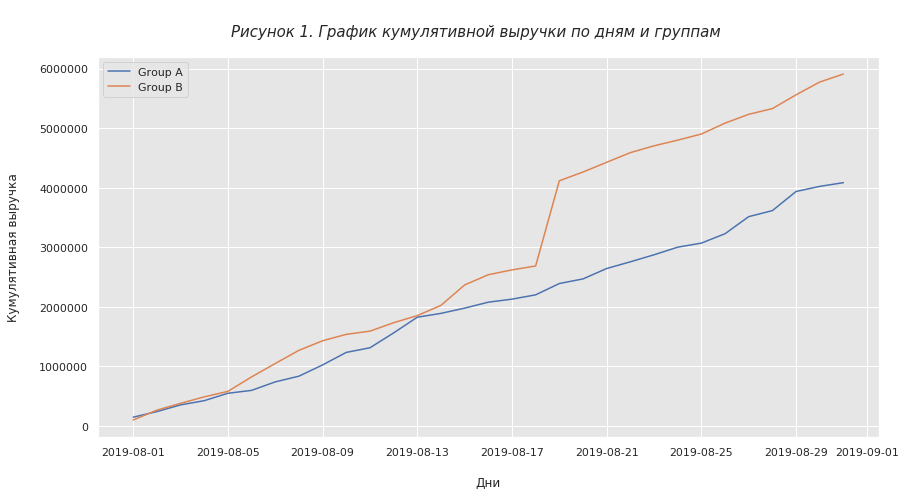

In [9]:
# строим график
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nРисунок 1. График кумулятивной выручки по дням и группам', fontsize=15, style="italic")

ax.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Group A')
ax.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Group B')

ax.legend(loc='upper left')
ax.set_ylabel('Кумулятивная выручка\n')
ax.set_xlabel('\nДни');

##### Вывод

Выручка увеличивается на протяжении всего теста. У группы ___B___ имеется резкий скачок - либо увеличение числа заказов, либо появление очень дорогих заказов. 

Построим график кумулятивного среднего чека по группам:

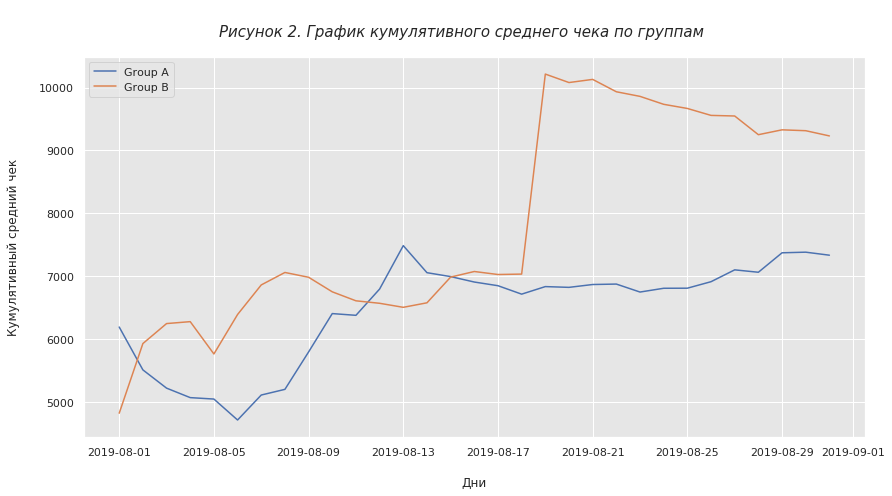

In [10]:
# строим график
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nРисунок 2. График кумулятивного среднего чека по группам', fontsize=15, style="italic")

ax.plot(cumulativeRevenueA['date'], 
        cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'],
        label='Group A')
ax.plot(cumulativeRevenueB['date'], 
        cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], 
        label='Group B')

ax.legend(loc='upper left')
ax.set_ylabel('Кумулятивный средний чек\n')
ax.set_xlabel('\nДни');

##### Вывод

К концу периода кумулятивный средний чек группы ___A___ стабилизировался, для группы ___B___ этот показатель недавно начал снижаться. Судя по всему, в группу ___B___ попали крупные заказы, поэтому для получения реального среднего чека необходимо больше данных. 

Построим график относительного изменения кумулятивного среднего чека группы B к группе A

In [11]:
# объединяем данные о кумулятивной выручке в один датафрейм
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])

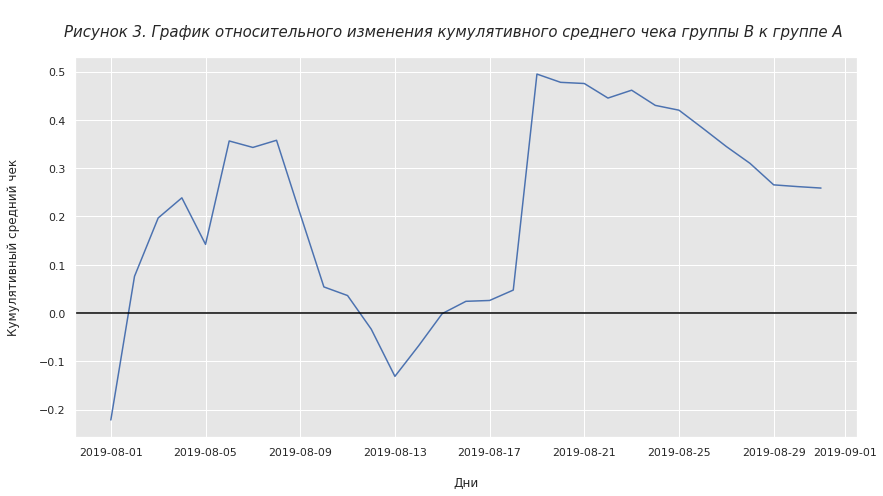

In [12]:
# строим график
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nРисунок 3. График относительного изменения кумулятивного среднего чека группы B к группе A',
             fontsize=15, 
             style="italic")

ax.plot(mergedCumulativeRevenue['date'], 
        (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) / 
        (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='-')

ax.set_ylabel('Кумулятивный средний чек\n')
ax.set_xlabel('\nДни');

##### Вывод

График не равномерный, имеет резкие скачки - это говорит о присутствующих выбросах и крупных заказах.

Построим график кумулятивной конверсии по группам

In [13]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# данные группы A
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

# данные группы B
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

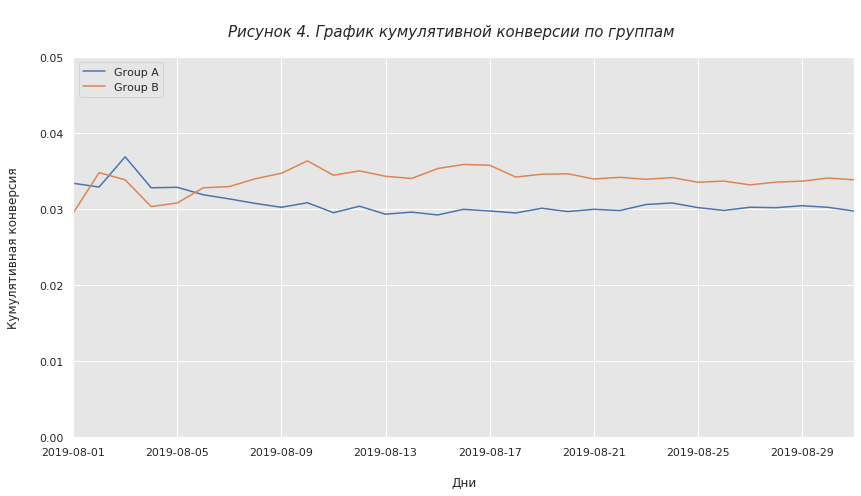

In [14]:
# строим график
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nРисунок 4. График кумулятивной конверсии по группам', fontsize=15, style="italic")

ax.plot(cumulativeDataA['date'], 
        cumulativeDataA['conversion'],
        label='Group A')
ax.plot(cumulativeDataB['date'], 
        cumulativeDataB['conversion'],
        label='Group B')

# задаем масштаб осей
plt.axis([cumulativeDataA['date'].min(),
          cumulativeDataA['date'].max(),
          0,
          .05])

ax.legend(loc='upper left')
ax.set_ylabel('Кумулятивная конверсия\n')
ax.set_xlabel('\nДни');

##### Вывод

Графики примерно симметричные - конверсия группы ___B___ стабильно выше конверсии группы ___A___.

Построим график относительного изменения кумулятивной конверсии группы B к группе A

In [15]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(
    cumulativeDataB[['date', 'conversion']],
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B'])

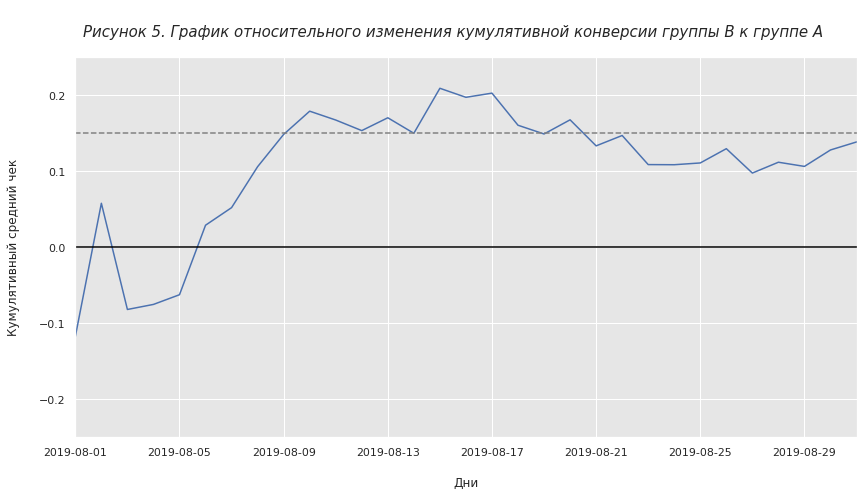

In [16]:
# строим график
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nРисунок 5. График относительного изменения кумулятивной конверсии группы B к группе A',
             fontsize=15, 
             style="italic")

ax.plot(mergedCumulativeConversions['date'], 
        mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=0.15, color='gray', linestyle='--')
# задаем масштаб осей
plt.axis([mergedCumulativeConversions['date'].min(),
          mergedCumulativeConversions['date'].max(),
          -.25,
          .25])
ax.set_ylabel('Кумулятивный средний чек\n')
ax.set_xlabel('\nДни');

##### Вывод

Отнонешие конверсии группы ___B___ к конверсии группы ___A___ в начале теста просело, затем график пошел вверх.

Проанализируем выбросы. Построим точечный график количества заказов по пользователям

In [17]:
orders_by_buyers = orders.pivot_table(index='visitorId', 
                                      values='transactionId', 
                                      aggfunc=pd.Series.nunique).reset_index()
orders_by_buyers.columns = ['buyers','orders']

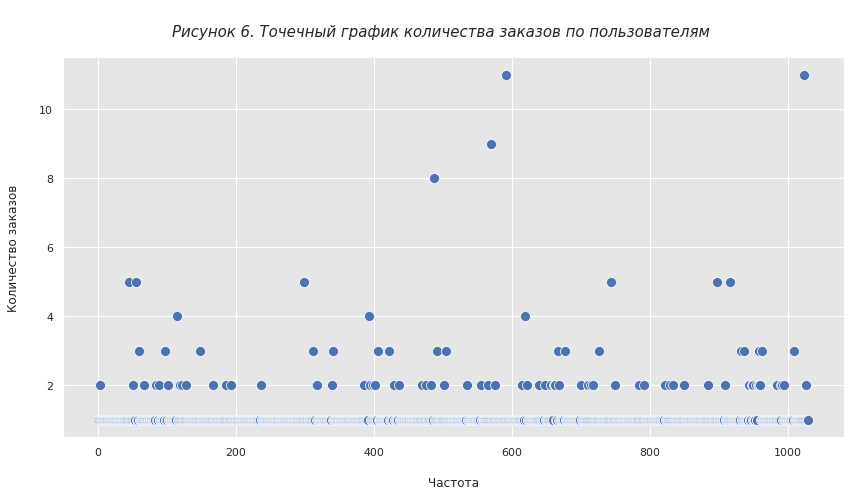

In [18]:
# строим график
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nРисунок 6. Точечный график количества заказов по пользователям',
             fontsize=15, 
             style="italic")

ax = sns.scatterplot(x=range(0,len(orders_by_buyers['orders'])),
                     y="orders", 
                     data=orders_by_buyers, alpha=1,
                     s=100)

ax.set_ylabel('Количество заказов\n')
ax.set_xlabel('\nЧастота');

##### Вывод

Большинство пользователей совершает 1-3 заказа. Для точного определения порога аномалий рассчитаем 95 и 99 перцентили. 

In [19]:
print('95 и 99 перцентили количества заказов:')
np.percentile(orders_by_buyers['orders'], [95, 99])

95 и 99 перцентили количества заказов:


array([2., 4.])

##### Вывод

Границей для определения аномальных пользователей выбираем покупателей, совершивших больше 2-х покупок.

Построим точечный график стоимостей заказов.

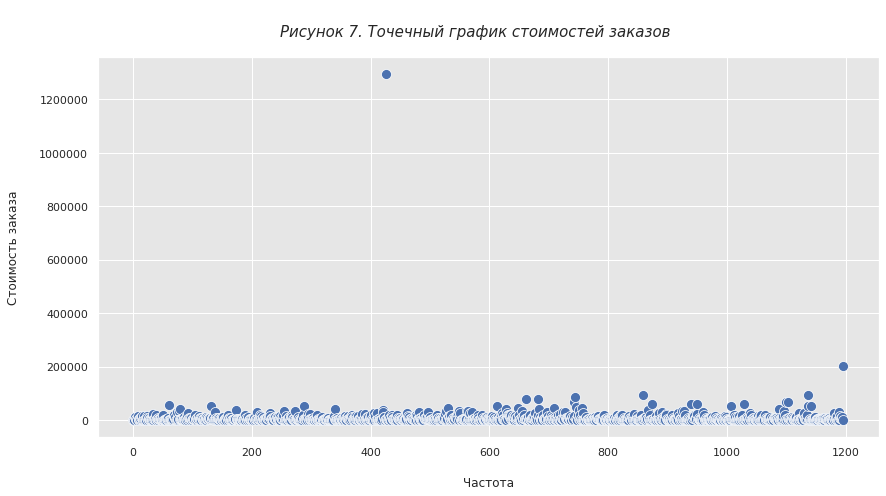

In [20]:
# строим график
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nРисунок 7. Точечный график стоимостей заказов',
             fontsize=15, 
             style="italic")

ax = sns.scatterplot(x=range(0,len(orders['revenue'])),
                     y="revenue", 
                     data=orders, alpha=1,
                     s=100)

ax.set_ylabel('Стоимость заказа\n')
ax.set_xlabel('\nЧастота');

##### Вывод

Большинство пользователей совершает покупки в пределах 200000. Найдем 95 и 99 перцентили для определения порога аномальных пользователей. 

In [21]:
print('95 и 99 перцентили количества заказов:')
np.percentile(orders['revenue'], [95, 99])

95 и 99 перцентили количества заказов:


array([28000. , 58233.2])

##### Вывод

Границей для определения аномальных пользователей выбираем покупки суммой более 28000.

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [22]:
# формируем датафрейм с требуемыми для анализа данными
cumulativeDataMerged = cumulativeDataA.merge(cumulativeDataB,
                                             left_on='date',
                                             right_on='date',
                                             how='left',
                                             suffixes=['A', 'B'])\
                       .drop(['conversionA', 'conversionB', 'groupA', 'groupB',
                              'buyersA', 'buyersB'], axis=1)

cumulativeDataMerged.columns = ['date', 'ordersCumulativeA', 'revenueCumulativeA', 'visitorsCumulativeA', 
                                        'ordersCumulativeB', 'revenueCumulativeB', 'visitorsCumulativeB']

In [23]:
# находим число посетителей для каждой группы в день
    # A
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

    # B
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [24]:
# находим количество заказов и сумму покупок в день для обоих групп
    # A
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

    # B
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [25]:
# сводим в один датафрейм
cumulativeDataMerged = cumulativeDataMerged.merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersADaily, left_on='date', right_on='date', how='left')\
    .merge(ordersBDaily, left_on='date', right_on='date', how='left')\

In [26]:
# находим количество пользователей, совершивших заказ, для обеих групп
    # A
ordersByUsersA = orders[orders['group'] == 'A'].groupby('visitorId', as_index=False)\
    .agg({'transactionId': pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

    # B
ordersByUsersB = orders[orders['group'] == 'B'].groupby('visitorId', as_index=False)\
    .agg({'transactionId': pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

In [27]:
# создаем списки всех пользователей с соответствующим количеством заказов. 0 - у тех, кто заказ не делал
sampleA = pd.concat([ordersByUsersA['orders'], 
                     pd.Series(0, 
                               index=np.arange(cumulativeDataMerged['visitorsPerDateA'].sum() - 
                                               len(ordersByUsersA['orders'])), 
                               name='orders')],
                    axis=0)

sampleB = pd.concat([ordersByUsersB['orders'], 
                     pd.Series(0, 
                               index=np.arange(cumulativeDataMerged['visitorsPerDateB'].sum() -
                                               len(ordersByUsersB['orders'])), 
                               name='orders')],
                    axis=0)

In [28]:
print('P-Value: {0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное отличие группы B от A: {0:.3f}'.format(sampleB.mean()/sampleA.mean()-1))

P-Value: 0.008
Относительное отличие группы B от A: 0.138


##### Вывод

Различие между конверсиями групп по "сырым" данным ститистически значимо, относительное различие составляет около 14%. 

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

In [29]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(
    orders[orders['group']=='A']['revenue'], 
    orders[orders['group']=='B']['revenue'])[1]))
print('Различие в среднем чеке группы B от группы A: {0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))


P-value: 0.365
Различие в среднем чеке группы B от группы A: 0.259


##### Вывод

Различие между средними чеками статистически не значимы, поэтому нельзя отвергнуть гипотезу, что средние чеки не различаются. В то же время, средний чек группы ___B___ значительно больше (на 26%) среднего чека группы ___A___.

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Отфильтруем аномальных пользователей - с числом заказов больше 2 и совершивших заказы дороже 28 000.

In [30]:
# пользователи с большим количеством заказов
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis=0)

# пользователи с дорогими заказами
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

# сводим в один датафрейм
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)\
    .drop_duplicates().sort_values()                       

In [31]:
print('Количество аномальных пользователей:', abnormalUsers.shape[0])

Количество аномальных пользователей: 74


In [32]:
# выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, 
               index=np.arange(cumulativeDataMerged['visitorsPerDateA'].sum() - 
                               len(ordersByUsersA['orders'])),
               name='orders')],
    axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, 
               index=np.arange(cumulativeDataMerged['visitorsPerDateB'].sum() - 
                               len(ordersByUsersB['orders'])),
               name='orders')],
    axis=0)

Применяем статистический критерий Манна-Уитни к полученным выборкам:

In [33]:
print('P-Value: {0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное отличие группы B от A: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-Value: 0.007
Относительное отличие группы B от A: 0.173


##### Вывод

Результат теста конверсии по очищенным данным практически не изменился - различие между выборками статистически значимо. Отличие группы ___B___ выросло до 17%. 

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [34]:
print("P-Value: {0:.3f}".format(st.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A',
                          np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(orders['group']=='B',
           np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("Относительное отличие группы B от A: {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',
                          np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

P-Value: 0.369
Относительное отличие группы B от A: -0.020


##### Вывод

По очищенным данным различие средних чеков статистически не значимо. Разница между группами практически отсутствует.

## Вывод

Результаты теста:
 - зафиксировано статистически значимое различие конверсий групп ___B___ и ___A___, как по сырым данным, так и после фильтрации аномалий. Конверсия группы ___B___ выше
 - не удалось зафиксировать статистически значимое различие средних чеков двух групп ни по сырым данным, ни по очищенным. Сырые данные средних чеков группы ___B___  больше на 26% среднего чека группы ___A___
 - результат конверсии группы ___B___ стабильно выше результата группы ___A___ *(рис. 5)*, имеет тенденцию к росту
 - из графика различия среднего чека *(рис. 3)* можно судить о присутствии аномалий в сырых данных
 
Исходя из вышеперечисленного, разумно прекратить тест, зафиксировав победу группы ___B___. Несмотря на отсутствие различий в средних чеках двух групп, конверсия группы ___B___ больше, соответственно, изменения принесли результат - посещения стали чаще конвертироваться в заказы. 